In [49]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [50]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading Data

In [51]:
force = False
training_data = datasets.MNIST('data',train=True,download=force,transform=ToTensor())
test_data = datasets.MNIST('data',train=False,transform=ToTensor())

def load_gan_data(path = './data/MNIST_GENERATED.pth'):
    data = torch.load(path)
    return list((X,y) for X,y in zip(data['data'],data['label']))
gan_data = load_gan_data()

In [52]:
batch_size = 100
train_dataloader = DataLoader(training_data,batch_size=batch_size)
gan_dataloader = DataLoader(gan_data,batch_size=batch_size)
test_dataloader = DataLoader(test_data,batch_size=batch_size)


def print_shape(dataloader):
    X,y = next(iter(dataloader))
    print(f"step per epoch - {len(dataloader)}")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

print_shape(train_dataloader)
print_shape(gan_dataloader)
print_shape(test_dataloader)

step per epoch - 600
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64
step per epoch - 100
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64
step per epoch - 100
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64


# Model Development

In [53]:
class Digit_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=6, stride=2),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(288, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Develop Optimization Iteration

In [54]:
def train(dataloader, model, loss_fn, optimizer,scheduler):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        losses.append(loss.item())

    return sum(losses)/len(losses)

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss,correct

def plot_loss(metric_hist):
    import matplotlib.pyplot as plt
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle(f'Epoch - {len(metric_hist["train"]["loss"])}')
    ax1.plot(metric_hist["train"]["loss"],label='train loss')
    ax1.plot(metric_hist["test"]["loss"],label='test loss')
    ax1.legend()
    ax2.plot(metric_hist["test"]["accuracy"],label='accuarcy')
    ax2.legend()
    plt.show()

In [65]:
def save_checkpoint(model,checkpoint_path,metric_hist):
    torch.save({
        'model':model.state_dict(),
        'metric' : metric_hist
    },checkpoint_path)

def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path,map_location=device)
    model = Digit_Classifier().to(device)
    model.load_state_dict(checkpoint['model'])
    return model,checkpoint['metric']

def init_metric():
    metric_hist = {
        'train': {},
        'test' : {},
    }
    for k in metric_hist:
        metric_hist[k]['loss'] = []
        metric_hist[k]['accuracy'] = []
    return metric_hist

# Run the iteration

In [56]:
loss_fn = nn.CrossEntropyLoss()
epochs = 10 
max_learning_rate = 0.01

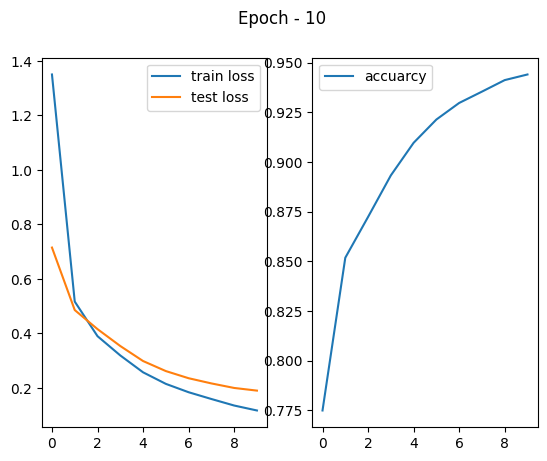

In [57]:
def fn():
    from IPython.display import clear_output
    
    model = Digit_Classifier().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                            max_lr = max_learning_rate,
                                            steps_per_epoch=len(gan_dataloader),
                                            epochs=epochs)
    
    metric_hist = init_metric()
    for t in range(epochs):
        loss = train(test_dataloader, model, loss_fn, optimizer,scheduler)
        
        metric_hist['train']['loss'].append(loss)
        test_loss,acc = test(train_dataloader, model, loss_fn)
        metric_hist['test']['loss'].append(test_loss)
        metric_hist['test']['accuracy'].append(acc)
        
        clear_output()
        plot_loss(metric_hist)
    
    checkpoint_path = "model_checkpoint/mnist_reduced_cnn.pth"
    save_checkpoint(model,checkpoint_path,metric_hist)
fn()

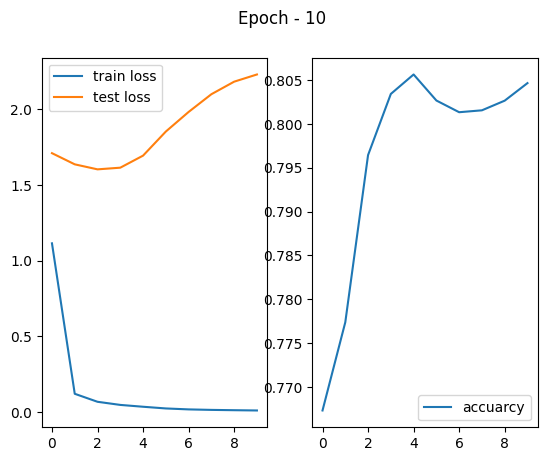

In [59]:
def fn():
    from IPython.display import clear_output
    
    model = Digit_Classifier().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                            max_lr = max_learning_rate,
                                            steps_per_epoch=len(gan_dataloader),
                                            epochs=epochs)
    
    metric_hist = init_metric()
    for t in range(epochs):
        loss = train(gan_dataloader, model, loss_fn, optimizer,scheduler)
        
        metric_hist['train']['loss'].append(loss)
        test_loss,acc = test(train_dataloader, model, loss_fn)
        metric_hist['test']['loss'].append(test_loss)
        metric_hist['test']['accuracy'].append(acc)
        
        clear_output()
        plot_loss(metric_hist)
    
    checkpoint_path = "model_checkpoint/mnist_reduced_cnn_gan.pth"
    save_checkpoint(model,checkpoint_path,metric_hist)
fn()

In [66]:
model = Digit_Classifier()
checkpoint_path = "model_checkpoint/mnist_reduced_cnn.pth"
model,*_ = load_checkpoint(checkpoint_path)
model.to(device)
loss_fn = nn.CrossEntropyLoss()

test(train_dataloader, model, loss_fn)

(0.18947430464283874, 0.944)

In [67]:
model = Digit_Classifier()
checkpoint_path = "model_checkpoint/mnist_reduced_cnn_gan.pth"
model,*_ = load_checkpoint(checkpoint_path)
model.to(device)
loss_fn = nn.CrossEntropyLoss()

test(train_dataloader, model, loss_fn)

(2.2308465092380843, 0.8046333333333333)